<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/RNN(5_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# -*- coding: utf-8 -*-
# RNN for Crop Production Classification (5 Classes)

# This script demonstrates how to build and train a Recurrent Neural Network (RNN)
# for classifying crop production levels into 5 classes based on tabular data using TensorFlow/Keras.

## 1. Setup and Imports

# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define file paths for session upload
TRAIN_PATH = "/content/drive/MyDrive/UpdatedDataset/train.csv"
VALID_PATH = "/content/drive/MyDrive/UpdatedDataset/validation.csv"
TEST_PATH = "/content/drive/MyDrive/UpdatedDataset/test.csv"


In [4]:

## 2. Load and Preprocess Data

def load_and_preprocess(file_path, scaler=None, fit_scaler=False, label_encoder=None, fit_encoder=False):
    """Loads data, preprocesses features, and converts target to 5 classes."""
    df = pd.read_csv(file_path)

    # Define class boundaries based on quantiles for 5 classes
    # Using 20%, 40%, 60%, and 80% quantiles for even distribution
    if fit_scaler:  # Only compute quantiles on training data
        quantiles = np.quantile(df["Production (M.Ton)"], [0.2, 0.4, 0.6, 0.8])
        feature_scaler = StandardScaler()
    else:
        # These will be provided from training data
        if scaler is None:
            raise ValueError("Scaler must be provided if fit_scaler is False")
        quantiles, feature_scaler = scaler  # Unpack the tuple of (quantiles, feature_scaler)

    # Create class labels based on quantiles
    bins = [-np.inf, quantiles[0], quantiles[1], quantiles[2], quantiles[3], np.inf]
    labels = ["very low", "low", "medium", "high", "very high"]

    # Convert target variable to classes
    df["Production_Category"] = pd.cut(df["Production (M.Ton)"], bins=bins, labels=labels, right=True)

    # Separate features and target
    X = df.drop(["Production (M.Ton)", "Production_Category"], axis=1)
    y = df["Production_Category"]

    # Identify numerical features (excluding one-hot encoded Crop and District)
    # Assuming columns starting with 'Crop_' or 'District_' are one-hot encoded
    numerical_cols = [col for col in X.columns if not col.startswith("Crop_") and not col.startswith("District_")]

    # Scale numerical features
    if fit_scaler:
        X[numerical_cols] = feature_scaler.fit_transform(X[numerical_cols])
    else:
        X[numerical_cols] = feature_scaler.transform(X[numerical_cols])

    # Encode labels
    if fit_encoder:
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
    else:
        if label_encoder is None:
            raise ValueError("LabelEncoder must be provided if fit_encoder is False")
        y_encoded = label_encoder.transform(y)

    # Convert labels to one-hot encoding
    y_one_hot = tf.keras.utils.to_categorical(y_encoded, num_classes=len(labels))

    # For RNN, reshape features to sequence format: (samples, timesteps, features)
    # We'll treat each feature as a timestep in a sequence
    X_reshaped = X.values.reshape((X.shape[0], X.shape[1], 1))

    if fit_scaler and fit_encoder:
        return X_reshaped, y_one_hot, (quantiles, feature_scaler), le
    elif fit_scaler:
         return X_reshaped, y_one_hot, (quantiles, feature_scaler)
    elif fit_encoder:
        return X_reshaped, y_one_hot, label_encoder
    else:
        return X_reshaped, y_one_hot

# Load and preprocess data
print("Loading and preprocessing training data...")
X_train, y_train, scalers, label_encoder = load_and_preprocess(TRAIN_PATH, fit_scaler=True, fit_encoder=True)

print("Loading and preprocessing validation data...")
X_val, y_val = load_and_preprocess(VALID_PATH, scaler=scalers, label_encoder=label_encoder)

print("Loading and preprocessing test data...")
X_test, y_test = load_and_preprocess(TEST_PATH, scaler=scalers, label_encoder=label_encoder)

quantiles, feature_scaler = scalers

print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Labels shape: {y_test.shape}")
print(f"Number of classes: {y_train.shape[1]}")
print(f"Class boundaries (quantiles): {quantiles}")
print(f"Class names: {label_encoder.classes_}")


Loading and preprocessing training data...
Loading and preprocessing validation data...
Loading and preprocessing test data...
Training data shape: (3942, 83, 1), Labels shape: (3942, 5)
Validation data shape: (845, 83, 1), Labels shape: (845, 5)
Test data shape: (845, 83, 1), Labels shape: (845, 5)
Number of classes: 5
Class boundaries (quantiles): [ 578.    1463.    3119.524 6540.92 ]
Class names: ['high' 'low' 'medium' 'very high' 'very low']


In [5]:

## 3. Build the RNN Model

def build_rnn_model(input_shape, num_classes):
    """Builds the RNN model for tabular data classification."""
    model = keras.Sequential([
        # Input layer
        keras.Input(shape=input_shape),

        # RNN layers
        layers.SimpleRNN(64, return_sequences=True),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.SimpleRNN(128),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Dense layers for classification
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Get input shape and number of classes from preprocessed data
input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
num_classes = y_train.shape[1]  # 5 classes

# Build the model
model = build_rnn_model(input_shape, num_classes)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 83, 64)         │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 83, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 83, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,277 (149.52 KB)

 Trainable params: 37,893 (148.02 KB)

 Non-trainable params: 384 (1.50 KB)

In [6]:
## 4. Train the Model

# Define training parameters
EPOCHS = 100
BATCH_SIZE = 64

# Add Early Stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)


Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - accuracy: 0.2509 - loss: 1.9751 - val_accuracy: 0.3254 - val_loss: 1.5466
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.2780 - loss: 1.7568 - val_accuracy: 0.3633 - val_loss: 1.4955
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.2932 - loss: 1.6376 - val_accuracy: 0.3231 - val_loss: 1.5039
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.2933 - loss: 1.5978 - val_accuracy: 0.3290 - val_loss: 1.4817
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.3267 - loss: 1.5243 - val_accuracy: 0.4201 - val_loss: 1.3635
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.3813 - loss: 1.4361 - val_accuracy: 0.4521 - val_loss: 1.2940
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.3856 - loss: 1.3702 - val_accuracy: 0.4059 - val_loss: 1.3476
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.4041 - loss: 1.3550 - val_accuracy: 

In [7]:


## 5. Evaluate the Model on Validation Data

# Get best validation accuracy from history
if 'val_accuracy' in history.history:
    best_val_accuracy = max(history.history['val_accuracy'])
    print(f"\nBest Validation Accuracy: {best_val_accuracy:.4f}")
else:
    print("\nValidation accuracy not available in history.")

# Evaluate the trained model on the validation dataset
print("\nEvaluating model on validation data...")
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Generate predictions on validation data
print("\nGenerating predictions on validation data...")
y_val_pred_proba = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_proba, axis=1)

# Convert one-hot encoded y_val back to single labels for comparison
y_val_labels = np.argmax(y_val, axis=1)

# Print Validation Classification Report
print("\nValidation Classification Report (includes Recall and F1-score):")
print(classification_report(y_val_labels, y_val_pred, target_names=label_encoder.classes_))

# Calculate and print Validation Macro F1 Score
val_macro_f1 = f1_score(y_val_labels, y_val_pred, average='macro')
print(f"\nValidation Macro F1 Score: {val_macro_f1:.4f}")

# Print Validation Confusion Matrix
print("\nValidation Confusion Matrix:")
val_cm = confusion_matrix(y_val_labels, y_val_pred)
print(val_cm)



Best Validation Accuracy: 0.7775

Evaluating model on validation data...
Validation Loss: 0.6173
Validation Accuracy: 0.7775

Generating predictions on validation data...
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

Validation Classification Report (includes Recall and F1-score):
              precision    recall  f1-score   support

        high       0.68      0.69      0.69       160
         low       0.70      0.79      0.74       140
      medium       0.77      0.61      0.68       191
   very high       0.81      0.89      0.85       169
    very low       0.90      0.91      0.91       185

    accuracy                           0.78       845
   macro avg       0.77      0.78      0.77       845
weighted avg       0.78      0.78      0.78       845


Validation Macro F1 Score: 0.7728

Validation Confusion Matrix:
[[111   4  23  22   0]
 [  5 110   9   3  13]
 [ 32  29 117   9   4]
 [ 15   1   1 151   1]
 [  1  14   1   1 168]]


In [8]:

## 6. Evaluate the Model on Test Data

# Evaluate the trained model on the test dataset
print("\nEvaluating model on test data...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions on test data
print("\nGenerating predictions on test data...")
y_test_pred_proba = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

# Convert one-hot encoded y_test back to single labels for comparison
y_test_labels = np.argmax(y_test, axis=1)

# Print Test Classification Report
print("\nTest Classification Report (includes Recall and F1-score):")
print(classification_report(y_test_labels, y_test_pred, target_names=label_encoder.classes_))

# Calculate and print Test Macro F1 Score
test_macro_f1 = f1_score(y_test_labels, y_test_pred, average='macro')
print(f"\nTest Macro F1 Score: {test_macro_f1:.4f}")

# Print Test Confusion Matrix
print("\nTest Confusion Matrix:")
test_cm = confusion_matrix(y_test_labels, y_test_pred)
print(test_cm)



Evaluating model on test data...
Test Loss: 0.5727
Test Accuracy: 0.7917

Generating predictions on test data...
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Test Classification Report (includes Recall and F1-score):
              precision    recall  f1-score   support

        high       0.71      0.77      0.74       175
         low       0.76      0.73      0.75       158
      medium       0.76      0.68      0.72       167
   very high       0.84      0.88      0.86       173
    very low       0.88      0.90      0.89       172

    accuracy                           0.79       845
   macro avg       0.79      0.79      0.79       845
weighted avg       0.79      0.79      0.79       845


Test Macro F1 Score: 0.7897

Test Confusion Matrix:
[[134   5  14  22   0]
 [  3 116  19   1  19]
 [ 32  15 113   5   2]
 [ 20   0   1 152   0]
 [  0  16   2   0 154]]


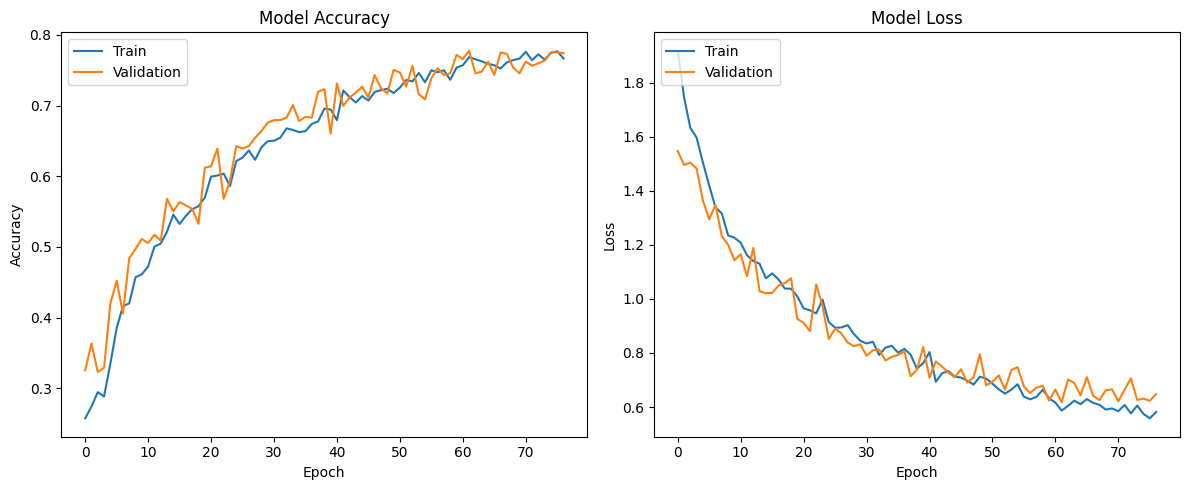

In [9]:

## 7. Visualize Results

# Plot training history and confusion matrices

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"])
if 'val_accuracy' in history.history:
    plt.plot(history.history["val_accuracy"])
    plt.legend(["Train", "Validation"], loc="upper left")
else:
    plt.legend(["Train"], loc="upper left")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"])
if 'val_loss' in history.history:
    plt.plot(history.history["val_loss"])
    plt.legend(["Train", "Validation"], loc="upper left")
else:
    plt.legend(["Train"], loc="upper left")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.tight_layout()
plt.show()


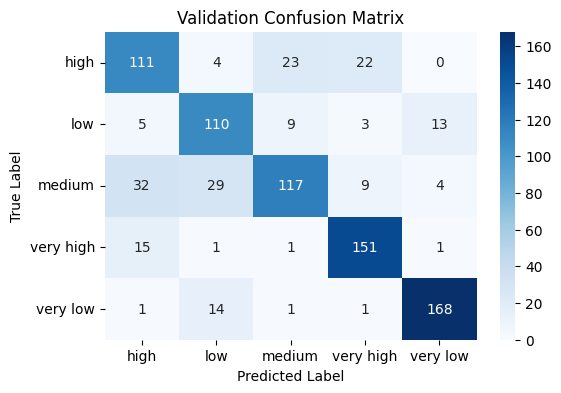

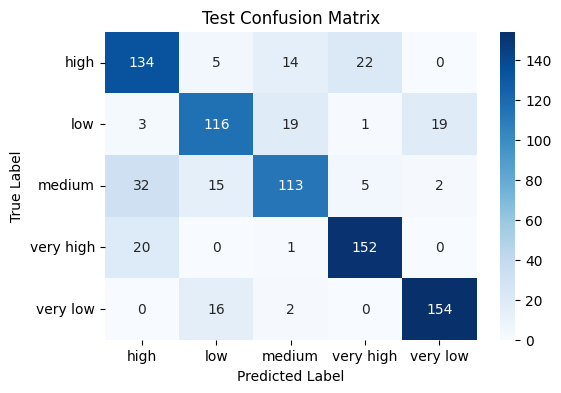

In [10]:

# Plot Validation Confusion Matrix Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(val_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Validation Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Plot Test Confusion Matrix Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Test Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


In [11]:

## 8. Summary of Results

print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Macro F1 Score: {val_macro_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Macro F1 Score: {test_macro_f1:.4f}")
print("="*60)

print("\n--- End of Script ---")


FINAL RESULTS SUMMARY
Validation Accuracy: 0.7775
Validation Macro F1 Score: 0.7728
Test Accuracy: 0.7917
Test Macro F1 Score: 0.7897

--- End of Script ---
